In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import save, load
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

import gc

In [2]:
#fds.list_builders()

In [3]:
ds = 'malaria'
builder = tfds.builder(ds)
info = builder.info
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images
    with equal instances of parasitized and uninfected cells from the thin blood 
    smear slide images of segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='C:\\Users\\edmun\\tensorflow_datasets\\malaria\\1.0.0',
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear image

## Loading the data

In [4]:

ds_all, ds_all_info = tfds.load(name='malaria', split="train", shuffle_files=True, with_info=True)

train_ds, val_ds, test_ds = tfds.load(ds, split=['train[:25%]', 'train[70%:75%]', 'train[85%:90%]'])


In [5]:
print("Number of prediction classes:", ds_all_info.features['label'].num_classes)
print("Prediction classes:", ds_all_info.features['label'].names)

Number of prediction classes: 2
Prediction classes: ['parasitized', 'uninfected']


In [6]:
no_train = tf.data.experimental.cardinality(train_ds).numpy()
no_valid = tf.data.experimental.cardinality(val_ds).numpy()
no_test = tf.data.experimental.cardinality(test_ds).numpy()

In [7]:
print("Number of training images:", no_train)
print("Number of validating images:", no_valid)
print("Number of testing images:", no_test)

Number of training images: 6890
Number of validating images: 1377
Number of testing images: 1378


## Showing Examples

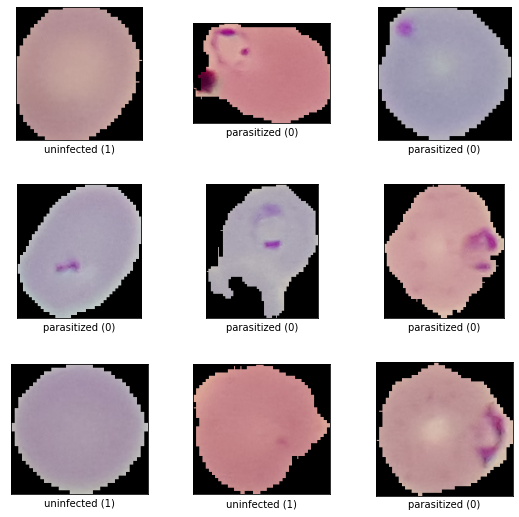

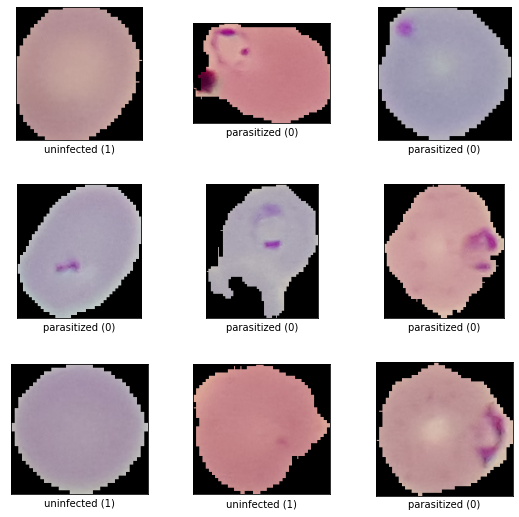

In [8]:
tfds.show_examples(ds_all, info)

## Data Preparation   

Extracting the images

In [9]:
train_images = np.array([example['image'].numpy() for example in train_ds] , dtype="object")
train_labels = [example['label'] for example in train_ds]

val_images = np.array([example['image'].numpy() for example in val_ds] , dtype="object")
val_labels = [example['label'] for example in val_ds]

test_images = np.array([example['image'].numpy() for example in test_ds] , dtype="object")
test_labels = [example['label'] for example in test_ds]

Checking to see the consistency in image lengths. 


In [10]:
c = 0
for i in train_images:
    print(i.shape)
    c+=1
    if c > 25:
        break

(103, 103, 3)
(106, 121, 3)
(139, 142, 3)
(130, 118, 3)
(121, 109, 3)
(127, 121, 3)
(166, 151, 3)
(145, 139, 3)
(139, 142, 3)
(172, 145, 3)
(157, 166, 3)
(115, 88, 3)
(115, 136, 3)
(142, 136, 3)
(115, 133, 3)
(124, 127, 3)
(136, 121, 3)
(118, 118, 3)
(124, 106, 3)
(142, 181, 3)
(139, 133, 3)
(127, 130, 3)
(157, 136, 3)
(136, 151, 3)
(106, 118, 3)
(130, 127, 3)


The images are of different lengths. We need to pad/crop the images to achieve images of same lengths.

In [11]:
gc.collect()

69

In [12]:
try:
    train_images = load('train_images.npy',  allow_pickle=True)
    print("Numpy file found and loaded.")
except FileNotFoundError:
    print("Training Images Numpy file not yet created. Creating one now.")
    for i in range(len(train_images)):
        train_images[i] = tf.image.resize_with_crop_or_pad(train_images[i], 200, 200)
        train_images[i] = tf.image.convert_image_dtype(train_images[i], tf.float64)
        train_images[i] = tf.reshape(train_images[i], [200,200,3])
    train_images = tf.constant(tf.stack([i.numpy() for i in train_images])).numpy()
    save('train_images.npy', train_images)

Numpy file found and loaded.


In [13]:
train_labels = tf.constant(tf.stack([i.numpy() for i in train_labels])).numpy()

In [14]:
gc.collect()

11

In [15]:
try:
    val_images = load('val_images.npy',  allow_pickle=True)
    print("Numpy file found and loaded.")
except FileNotFoundError:
    print("Validating Images Numpy file not yet created. Creating one now.")
    for i in range(len(val_images)):
        val_images[i] = tf.image.resize_with_crop_or_pad(val_images[i], 200, 200)
        val_images[i] = tf.image.convert_image_dtype(val_images[i], tf.float64)
        val_images[i] = tf.reshape(val_images[i], [200,200,3])
    val_images = tf.constant(tf.stack([i.numpy() for i in val_images])).numpy()
    save('val_images.npy', val_images)

Numpy file found and loaded.


In [16]:
val_labels = tf.constant(tf.stack([i.numpy() for i in val_labels])).numpy()

In [17]:
try:
    test_images = load('test_images.npy',  allow_pickle=True)
    print("Numpy file found and loaded.")
except FileNotFoundError:
    print("Testing Images Numpy file not yet created. Creating one now.")
    for i in range(len(test_images)):
        test_images[i] = tf.image.resize_with_crop_or_pad(test_images[i], 200, 200)
        test_images[i] = tf.image.convert_image_dtype(test_images[i], tf.float64)
        test_images[i] = tf.reshape(test_images[i], [200,200,3])
    test_images = tf.constant(tf.stack([i.numpy() for i in test_images])).numpy()
    save('test_images.npy', test_images)

Numpy file found and loaded.


In [18]:
test_labels = tf.constant(tf.stack([i.numpy() for i in test_labels])).numpy()

In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

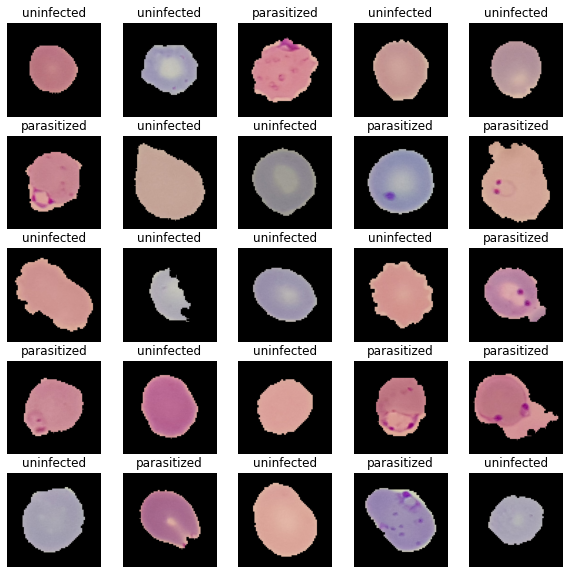

In [20]:
show_batch(train_images, train_labels)

## Model Building

In [134]:
gc.collect()

58061

## Basic Model

We will first construct a basic model to see how one fares with the training and validating sets.

In [143]:
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images,train_labels, epochs=10, batch_size=32)

Epoch 1/10
216/216 [==============================] - 52s 231ms/step - loss: 3.5688 - accuracy: 0.5473
Epoch 2/10
216/216 [==============================] - 49s 227ms/step - loss: 0.7330 - accuracy: 0.5875
Epoch 3/10
216/216 [==============================] - 47s 219ms/step - loss: 0.6940 - accuracy: 0.5907
Epoch 4/10
216/216 [==============================] - 46s 215ms/step - loss: 0.6722 - accuracy: 0.6296
Epoch 5/10
216/216 [==============================] - 46s 214ms/step - loss: 0.6548 - accuracy: 0.6302
Epoch 6/10
216/216 [==============================] - 48s 223ms/step - loss: 0.6716 - accuracy: 0.5761
Epoch 7/10
216/216 [==============================] - 50s 232ms/step - loss: 0.6870 - accuracy: 0.5351
Epoch 8/10
216/216 [==============================] - 50s 233ms/step - loss: 0.6875 - accuracy: 0.5318
Epoch 9/10
216/216 [==============================] - 50s 230ms/step - loss: 0.6855 - accuracy: 0.5344
Epoch 10/10
216/216 [==============================] - 50s 229ms/step - l

This basic model will serve as a baseline. As we can see, the model does not perform well on the training set. The accuracy is only 0.5560.

In [136]:
gc.collect()

2338

## Convolutional Model

Next, we will construct our deep Convolutional Neural Network. We will create classes for Convulation block and dense block for easy implementation later on.

In [21]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Model construction. We will use a combination of convolutional and dense layers

In [22]:
def build_model():
    model = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(200, 200, 3)),
        conv_block(16),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        dense_block(32, 0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

Compiling our model. We will use accuracy as the metrics for success.

In [26]:
model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

## Callbacks

We will contruct callbacks for our model. Firstly, we create a model checkpoint that will save our best model. Next, we will initiate early stopping condition to save time during training if the model stops improving.

In [24]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

## Model Training

In [27]:
history = model.fit(
    train_images, train_labels, 
    epochs=20, 
    batch_size = 32, 
    validation_data=(val_images,val_labels), 
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/20
216/216 [==============================] - 229s 1s/step - loss: 0.7927 - accuracy: 0.5441 - auc: 0.5601 - val_loss: 0.7084 - val_accuracy: 0.4975 - val_auc: 0.5000
Epoch 2/20
216/216 [==============================] - 230s 1s/step - loss: 0.7130 - accuracy: 0.5848 - auc: 0.6103 - val_loss: 0.9869 - val_accuracy: 0.4975 - val_auc: 0.5000
Epoch 3/20
216/216 [==============================] - 218s 1s/step - loss: 0.6719 - accuracy: 0.6118 - auc: 0.6556 - val_loss: 1.1704 - val_accuracy: 0.4975 - val_auc: 0.6540
Epoch 4/20
216/216 [==============================] - 234s 1s/step - loss: 0.5758 - accuracy: 0.7017 - auc: 0.7724 - val_loss: 1.5878 - val_accuracy: 0.5018 - val_auc: 0.8728
Epoch 5/20
216/216 [==============================] - 222s 1s/step - loss: 0.2606 - accuracy: 0.9132 - auc: 0.9570 - val_loss: 0.3895 - val_accuracy: 0.8896 - val_auc: 0.9700
Epoch 6/20
216/216 [==============================] - 232s 1s/step - loss: 0.1972 - accuracy: 0.9406 - auc: 0.9701 - val_loss

## Model Evaluation

In [28]:
model.evaluate(test_images,test_labels)

44/44 [==============================] - 11s 242ms/step - loss: 0.2442 - accuracy: 0.9427 - auc: 0.9843


[0.24419350922107697, 0.9426705241203308, 0.984270453453064]

Accuracy: 0.9427 for the test data. 

AUC: 0.9843 for the test data. 

The model has high discriminatory power and is highly accurate.

In [29]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 100, 100, 16)      571       
_________________________________________________________________
sequential_11 (Sequential)   (None, 50, 50, 32)        2160      
_________________________________________________________________
sequential_12 (Sequential)   (None, 25, 25, 64)        7392      
_________________________________________________________________
sequential_13 (Sequential)   (None, 12, 12, 128)       27072     
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 6, 6, 256)         103296    
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 256)       